# 2025년 10월 1일 LangGraph

## 간단한 chatbot 만들기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv(override=True)
api_key = os.getenv("OPENAI_API_KEY")
default_model = os.getenv("OPENAI_DEFAULT_MODEL")
redis_host = os.getenv("REDIS_HOST")
redis_password = os.getenv("REDIS_PASSWORD")
tavily_key = os.getenv("TAVILY_API_KEY")


### langgraph에 필요한 요소들
- state : 메세지를 주고받으면서 관리할 데이터를 명확하게 정의
- node
- edge  

- state 정의

In [2]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[List, add_messages]

- LLM 정의

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(api_key=api_key, model_name = default_model)

c:\Users\edukd\miniconda3\envs\myKDA2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def chatbot (state:State):
    response = llm.invoke(state['messages'])
    return {"messages" : [response]}

In [5]:
from langgraph.graph import StateGraph, START, END
workflow = StateGraph(State)

workflow.add_node("chatbot", chatbot)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

graph = workflow.compile()

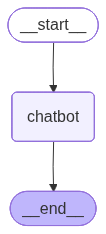

In [6]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# 다음에도 사용할 내용입니다

from langchain_core.messages import HumanMessage

while True:
    user_input = input("질문을 하세요 : ")
    if user_input.strip() in ['q', 'ㅂ']:
        break
    
    state = {"messages":[HumanMessage(content=user_input)]}
    response = graph.invoke(state)
    print(response['messages'][-1].content)
    print("\n")

In [9]:
for i, msg in enumerate(state['messages']):
    if isinstance(msg, HumanMessage):
        print(f"{i} (Human): {msg.content}")

NameError: name 'state' is not defined

In [10]:
# 다음에도 사용할 내용입니다

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

state = {"messages":[SystemMessage(content=user_input)]}
while True:
    user_input = input("질문을 하세요 : ")
    if user_input.strip() in ['q', 'ㅂ']:
        break
    
    state['messages'].append(HumanMessage(content=user_input))
    response = graph.invoke(state)
    state['messages'].append(AIMessage(content=response['messages'][-1].content))
    print(response['messages'][-1].content)
    print("\n")

- 외부 검색 툴을 사용하기

- 검색 도구 - tavily

In [11]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(tavily_api_key= tavily_key, max_results=3)
search_tool.invoke("LangChain이 무엇인가요?")


{'query': 'LangChain이 무엇인가요?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://aws.amazon.com/ko/what-is/langchain/',
   'title': 'LangChain이란 무엇인가요? - AWS',
   'content': '예를 들어 개발자는 LangChain 구성 요소를 사용하여 새 프롬프트 체인을 구축하거나 기존 템플릿을 맞춤화할 수 있습니다. 개발자는 시퀀스를 사용자 지정하여 복잡한 애플리케이션을 빠르게 구축할 수 있습니다. LangChain에서 개발자는 원하는 결과를 생성하는 데 필요한 단계를 지정하여, 특정 비즈니스 상황에 맞게 언어 모델을 유연하게 조정할 수 있습니다. 소프트웨어 팀은 LangChain을 사용하여 다음 모듈로 컨텍스트 인식 언어 모델 시스템을 구축할 수 있습니다. 개발자는 챗봇 애플리케이션 또는 퓨샷 학습을 위한 프롬프트 템플릿을 만들거나, 언어 모델에 구체적인 지침을 제공할 수 있습니다. LangChain을 사용하면 언어 모델 응답을 개선하는 정보를 변환하고, 저장하고, 검색하고, 가져오는 다양한 도구를 사용하여 RAG 시스템을 설계할 수 있습니다. Amazon Bedrock, Amazon Kendra, Amazon SageMaker JumpStart, LangChain 및 LLM을 사용하여 엔터프라이즈 데이터를 기반으로 매우 정확한 생성형 인공 지능(생성형 AI) 애플리케이션을 구축할 수 있습니다.',
   'score': 0.98562,
   'raw_content': None},
  {'url': 'https://www.samsungsds.com/kr/insights/what-is-langchain.html',
   'title': '랭체인 LangChain 이란 무엇인가? | 인사이트리포트 | 삼성SDS',
   'content': '**LangChain(랭체인)

- LLM 모델 설정 & Tools 바인딩

In [12]:
tools = [search_tool]
llm_with_tools = llm.bind_tools(tools=tools)

In [13]:
def chatbot_with_tools(state:State):
    response = llm_with_tools.invoke(state['messages'])
    return {"messages":[response]}

In [14]:
from langchain_core.messages import ToolMessage
import json

class ToolNode:
    def __init__(self, tools):
        self.tools_by_name = {tool.name: tool for tool in tools} #툴 정보매핑

    def __call__(self, inputs):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in inputs.")

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args'])
            tool_message = ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call['name'],
                tool_call_id=tool_call['id'],
            )
            outputs.append(tool_message)

        return {"messages": outputs}   

tool_node = ToolNode(tools)

- 조건부 edge를 위한 조건 함수

In [15]:
def tools_condition(state:State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return 'tools'
    return END

In [16]:
workflow = StateGraph(State)

workflow.add_node("chatbot_with_tools", chatbot_with_tools)
workflow.add_node("tools", tool_node)

workflow.add_conditional_edges("chatbot_with_tools", 
                            tools_condition,
                            {"tools":"tools",END:END})
workflow.add_edge("tools",  "chatbot_with_tools")
workflow.add_edge(START, "chatbot_with_tools")
workflow.add_edge("chatbot_with_tools", END)
graph = workflow.compile()

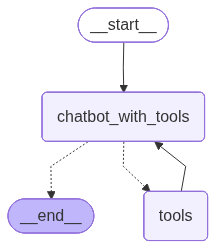

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png())) #한번 실행하고 끝

In [18]:
from langchain_core.messages import HumanMessage

user_input = "LangGraph에서 '노드'란 무엇인가요?"
state = {"messages": [HumanMessage(content=user_input)]}
response = graph.invoke(state)

print(response["messages"][-1].content)

LangGraph에서 '노드'(Node)는 기본적으로 그래프의 구성 요소로, 특정 작업이나 상태를 나타내는 객체입니다. 노드는 일반적으로 메시지를 주고받으며, 이를 통해 작업을 수행하거나 상태를 변환합니다. 예를 들어, 특정 노드가 작업을 완료하면, 다른 노드로 메시지를 전달하여 이후의 프로세스를 이어갑니다.

노드는 그래프 내에서 기능을 수행하는 역할을 하며, 각 노드는 다른 요소와 연결될 수 있는 방법으로 정의됩니다. 예를 들어, "increment"라는 이름의 노드는 카운터 상태를 증가시키는 기능을 수행할 수 있습니다.

이와 관련된 추가적인 정보는 다음의 링크에서 확인할 수 있습니다:
- [LangGraph 노드 설명 - WikiDocs](https://wikidocs.net/261580)
- [LangGraph Concepts - GitHub Pages](https://langchain-ai.github.io/langgraph/concepts/low_level/)


- 체크포인트 설정

In [19]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [20]:
from langgraph.checkpoint.redis import RedisSaver
host = "redis_host: 10480"

memory1 = RedisSaver.from_conn_string(host)

In [21]:
workflow = StateGraph(State)

workflow.add_node("chatbot_with_tools", chatbot_with_tools)
workflow.add_node("tools", tool_node)

workflow.add_conditional_edges("chatbot_with_tools", 
                            tools_condition,
                            {"tools":"tools",END:END})
workflow.add_edge("tools",  "chatbot_with_tools")
workflow.add_edge(START, "chatbot_with_tools")
workflow.add_edge("chatbot_with_tools", END)
graph = workflow.compile(checkpointer=memory)

- checkpoint --> configurable, thread_id

In [22]:
config = {"configurable" : {"thread_id" : "user123"}}


In [29]:
from langchain_core.messages import HumanMessage
# 첫번째 질문
user_input1 = "LangGraph가 뭐에요?"
state1 = {"messages":[HumanMessage(content=user_input1)]}
result1 = graph.invoke(state1, config)
print(result1['messages'][-1].content)

14:31:36 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
LangGraph는 LangChain에서 개발한 오픈 소스 AI 에이전트 프레임워크로, 복잡한 생성 AI 에이전트 워크플로우를 구축, 배포 및 관리하는 데 사용됩니다. 이 프레임워크는 대규모 언어 모델(LLM)을 효율적으로 운영할 수 있도록 지원하며, 그래프 기반 아키텍처를 사용하여 다양한 구성 요소 간의 복잡한 관계를 모델링합니다.

LangGraph는 개발자가 더 정교한 AI 모델을 만들 수 있도록 하며, 예를 들어 노르웨이 크루즈 라인에서는 고객 맞춤형 AI 솔루션을 개발하는 데 LangGraph를 활용하고 있습니다. 이 프레임워크는 사이클릭 그래프 토폴로지를 통해 에이전트의 행동을 더욱 다양하고 유연하게 만들 수 있는 기능을 제공합니다. 

그 외에도 LangGraph는 에이전트들이 과거의 행동과 피드백을 분석하여 의사 결정을 향상시키는 데 도움을 줌으로써, 최적의 성능을 낼 수 있도록 설계되었습니다.


In [30]:
snap = graph.get_state(config)
snap.values['messages']

[HumanMessage(content='LangGraph가 뭐에요?', additional_kwargs={}, response_metadata={}, id='346e5092-d11f-4470-bb20-a5f218ee3486'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LB2D50mwP79KVfWfUBIB2GNj', 'function': {'arguments': '{"query":"LangGraph","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 1275, 'total_tokens': 1297, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CLjdfk692wsHVvMvHAMrHzANO3bvu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f7a3a653-b146-4464-a4d3-dc2070dce625-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'LangGr

In [33]:
user_input2 = "그것을 만든 회사는 어딘가요?"
state2 = {"messages": [HumanMessage(content=user_input2)]}
response2 = graph.invoke(state2, config)

# 챗봇의 두 번째 응답 출력 (이전 대화의 맥락이 유지된 상태)
print(response2["messages"][-1].content)

14:32:20 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
LangGraph는 LangChain이라는 회사에 의해 개발되었습니다. LangChain은 AI 에이전트와 관련된 다양한 도구와 라이브러리를 제공하는 전문 회사입니다.


In [35]:
# 세 번째 대화: 새로운 thread_id 사용하여 독립된 새로운 대화 맥락 생성
user_input3 = "그 LangGraph를 만든 회사는 어디에 위치해 있나요?"
state3 = {"messages": [HumanMessage(content=user_input3)]}
response3 = graph.invoke(state3, {"configurable": {"thread_id": "user456"}})
print(response3["messages"][-1].content)
# 새로운 대화 맥락에서의 챗봇 응답 출력 (기존 thread_id와 독립된 상태)print(response3["messages"][-1].content)

14:33:34 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
14:33:40 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
LangGraph는 LangChain의 일부로, LangChain은 AI 애플리케이션을 개발하는 플랫폼입니다. 그러나 해당 회사의 구체적인 위치에 대한 정보는 명시되어 있지 않은 것 같습니다.

이와 관련된 더 많은 정보를 원하시면, [LangChain의 공식 웹사이트](https://www.langchain.com/about)를 방문해 보시는 것이 좋습니다.


In [36]:
graph.get_state({"configurable" : {"thread_id":"user456"}}).values['messages']

[HumanMessage(content='그것을 만든 회사는 어딘가요?', additional_kwargs={}, response_metadata={}, id='2be1c6f0-9b53-4fc7-8299-1da5c3142f7e'),
 AIMessage(content='"그것"이 무엇을 의미하는지 명확하지 않습니다. 더 구체적인 질문이나 정보가 필요합니다. 어떤 제품이나 기술에 대해 언급하고 있는지 알려주시면, 더 정확한 정보를 제공할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1280, 'total_tokens': 1331, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CLjgi66odGS90m1D7yYtBqtC2KVgD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--bd3c4a25-6ad9-4db5-9038-eef3879a26c5-0', usage_metadata={'input_tokens': 1280, 'output_tokens': 51, 'total_tokens': 1331, 'input_token_details': {'audio': 0, 'cache_read': 1152}, 'output_

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated, List, Literal
from dotenv import load_dotenv
import os
from langgraph.types import interrupt, Command
from operator import add

NameError: name 'snapshot' is not defined